# source code

In [190]:
from random import *
from itertools import *
import numpy as np
from franke import FrankeFunction
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
%matplotlib inline

np.random.seed(69420666)

def create_data(points = 10000, noise = .01):
    
    x = np.random.random(size = points)
    y = np.random.random(size = points)
    z = FrankeFunction(x, y)
    
    if noise:
        z_noise = z + np.random.normal(0, noise, size = z.shape[0])
    
    return x, y, z, z_noise

class Regression_methods(object):
    def __init__(self, A, y, lamb = 0):
        try:
            A.shape       
        except AttributeError:
            A = np.array(A)
        try:
            y.shape
        except AttributeError:
            y = np.array(y)
        if A.shape[0] != y.shape[0]:
            msg = 'Matrix and Vector must have compatable dimensions for matrix math'
            raise Exception(msg)
        
        self._A = A
        self._y = y
        self._lamb = lamb
        self._hessian = A.T @ A
    
    @property
    def beta(self):
        try:
            return self._beta
        except:
            if (self._lamb == 0 or self._lamb == None):
                self._beta = np.linalg.pinv(self._hessian) @ self._A.T @ self._y
                #u,s,v = np.linalg.svd(self._A)
                #c = np.dot(u.T,self._y)
                #w = np.linalg.solve(np.diag(s),c)
                #self._beta = np.dot(v.T,w)
                return self._beta
            
            else:
                n = self._hessian.shape[0]
                self._beta = np.linalg.inv(self._hessian + self._lamb*np.eye(n)) @ self._A.T @ self._y
                return self._beta
    
    @property
    def y_tilde(self):
        try:
            return self._y_tilde
        except:
            self._y_tilde = self._A @ self.beta
            return self._y_tilde
    
    
    @property
    def sigma_y_sqr(self):
        n = self._y.size
        p = self._hessian.shape[0]
        self._sigma_y_sqr = 1/(n-p-1) * np.sum((self._y-self.y_tilde)**2)
        return self._sigma_y_sqr
    
    @property
    def beta_var(self):
        try:
            return self._beta_var
        except:
            self._beta_var = np.linalg.inv(self._hessian) * self.sigma_y_sqr
            return self._beta_var
    
    @property
    def hessian(self):
        return self._hessian
    
    def R2score(self): #FIX SHIT HERE!!!
        self.y_tilde
        return 1 - np.sum((self._y - self._y_tilde) ** 2) / np.sum((self._y - np.mean(self._y)) ** 2)

    def ms_error(self):
        self.y_tilde
        return np.sum((self._y-self._y_tilde)**2)/np.size(self._y_tilde)

    #def predict(self, X):
    #    return (X @ self.beta ).squeeze()
    

def no_resample_analysis(regression_object, method = 'ols', lamb = 0):
    
    n = regression_object._y.shape[0]
    
    if (method == 'ols'):
        betavar = np.diag(regression_object.beta_var)
        sigma = regression_object.sigma_y_sqr
        mse = regression_object.ms_error()
        r2 = regression_object.R2score()
        
    if (method == 'ridge'):
        sigma = regression_object.sigma_y_sqr
        x = regression_object.hessian
        W = np.linalg.inv(x+lamb*np.eye(x.shape[0]))@x
        betavar = np.diag(sigma*W@np.linalg.inv(x)@W.T)
        mse = regression_object.ms_error()
        r2 = regression_object.R2score()
    
    if (method == 'lasso'):
        
    
    
    
    print('NO RESAMPLE ANALYSIS')
    print('MSE: ', mse)
    print('R2 Score: ', r2)
    print('----Confidence Intervals for Selected Beta----')
    for i in range(len(betavar)):
        if i in np.arange(0,len(betavar)+1,2):
            print('\u03B2{:} = {:.3} +- {:.3}'.format(i, regression_object.beta[i], 1.645*np.sqrt(betavar[i]/n)))
    
    return betavar, sigma, mse, r2
    
def data_split(x_data, y_data, z_data, j):
    x_train=np.delete(x_data,j)
    y_train=np.delete(y_data,j)
    z_train=np.delete(z_data,j)
    x_test=np.take(x_data,j)
    y_test=np.take(y_data,j)
    z_test=np.take(z_data,j)
    
    return x_train, y_train, z_train, x_test, y_test, z_test       

        
def build_design_matrix(x1_data, x2_data, order):
    
    '''
    takes in sorted x and y data and creates a design matrix  of specified polynomial order
    x and y must be the same shape
    '''
    
    if x1_data.shape[0] != x2_data.shape[0]:
        msg = "\n\nArguments <x1> and <x2> in function <build_design_matrix> must be of "
        msg += f"the same shape."
        raise Exception(msg)
    
    if len(x1_data.shape) > 1:
        x1_data = np.ravel(x1_data)
        y1_data = np.ravel(y1_data)
        
    exponents = list(product(range(0,order+1), repeat=2)) #creates tupples of all combos from 0 to order
    expo_sum = np.sum(exponents, axis = 1) 
    valid_index = np.where(np.less_equal(expo_sum, order))[0] #collects index of sum(exponents) <= order
    exponents = np.array(exponents)
    exponents = exponents[valid_index] #only take in valid exponents
    
    design_matrix = np.zeros((x1_data.shape[0], exponents.shape[0]))
    for row in range(len(exponents)):
        for i in range(x1_data.shape[0]):
            design_matrix[i,row] = (x1_data[i]**exponents[row][0])*(x2_data[i]**exponents[row][1])
    return design_matrix        
        
def R2score(z, zhat):
    return 1 - np.sum((z - zhat) ** 2) / np.sum((z - np.mean(zhat)) ** 2)

def ms_error(z, zhat):
    return np.sum((z - zhat)**2)/np.size(zhat)

def bias(z,zhat):
    return np.mean((z - zhat)**2)
    
def my_kfold(xdata, ydata, zdata, model_type, lamb = 0, order = 5, k=5):
    '''
    take in x, y, z vectors from data set. 
    use model_type = 1 for OLS, =2 for Ridge, =3 for LASSO
    use poly_order to zet order of polynomial fit
    
    '''
    
    z_out = []
    x_out = []
    y_out = []
    
    error_test_local = 0
    error_train_local = 0
    r2_test_local = 0
    r2_train_local = 0
    
    error_global = 0
    bias_global = 0
    var_global = 0
    
    if (model_type == 'ols'):
        
        #q = int((order+1)*(order+2)/2)
        #beta_matrix = np.zeros((k,q)) # (k,number of poly terms) size matrix for beta
        
        xtr_global, xtst_global, ytr_global, ytst_global, ztr_global, ztst_global = train_test_split(xdata, 
                                                                                                     ydata, 
                                                                                                     zdata,
                                                                                                     test_size=0.2)
        d_tst_global = build_design_matrix(xtst_global, ytst_global, order)
        
        idx_vec = np.arange(len(xtr_global))
        L = int(len(idx_vec)/k)
        np.random.shuffle(idx_vec)
        
        Z = np.zeros((k, len(ztst_global)))
            
        for i in range(k):
            x_train, y_train, z_train, xtst_local, ytst_local, ztst_local = data_split(xtr_global, 
                                                                                       ytr_global, 
                                                                                       ztr_global,
                                                                                       idx_vec[i*L:(i+1)*L])
            
            d_train = build_design_matrix(x_train, y_train, order)
            d_tst_local = build_design_matrix(xtst_local, ytst_local, order)
             
            
            reg_object = Regression_methods(d_train, z_train, lamb = lamb)
            beta = reg_object.beta
            
            z_pred_train = d_train @ beta
            
            z_pred_local = d_tst_local @ beta
            
            Z[i] = d_tst_global @ beta
            
            #train / test error scores
            error_test_local += ms_error(ztst_local, z_pred_local)
            error_train_local += ms_error(z_train, z_pred_train)
            r2_test_local += R2score(ztst_local, z_pred_local)
            r2_train_local += R2score(z_train, z_pred_train)
                      
            z_out = np.concatenate((z_out, z_pred_local), axis = 0)
            x_out = np.concatenate((x_out, xtst_local), axis = 0)
            y_out = np.concatenate((y_out, ytst_local), axis = 0)
            
        #error_global = ms_error(ztst_global, np.mean(Z,axis=0))
        error_global = np.mean( np.mean((ztst_global - Z)**2, axis=0, keepdims=True) )        
        bias_global = np.mean( (ztst_global - np.mean(Z, axis=0, keepdims=True))**2 )
        var_global = np.mean(np.var(Z,axis=0))
        
        data = np.zeros((z_out.size,3))
        data[:,0] = x_out
        data[:,1] = y_out
        data[:,2] = z_out
         
        #print('{} >= {} + {} = {}'.format(MSE_, bias_, variance_, bias_+variance_))
       
        return data, error_test_local/k, error_train_local/k, r2_test_local/k, r2_train_local/k, error_global, bias_global, var_global
    


def bias_variance(xdata, ydata, zdata, model_type, lamb = 0, poly_order = 5, k=5, fitplot = False,
                 bvplot = False, testtrainplot = False, printval = False):
    '''
    This function performs a regression analysis specified by:
            
            model_type: 'ols', 'ridge', 'lasso'
    
    While doing k = 5 kfold cross validation resampling
    This is done for polynomial fits from:
    
            polynomial order = 1 to poly_order
    
    The bias variance tradeoff is then plotted vs polynomial order
    '''
    vec_size = poly_order + 1
    polynomial_vec = np.arange(vec_size)
   
    error_test = np.zeros(vec_size)
    error_train = np.zeros(vec_size)
    r2vec = np.zeros(vec_size)
    
    error_global = np.zeros(vec_size)
    bias_ = np.zeros(vec_size)
    variance = np.zeros(vec_size)
    
    for i in polynomial_vec:
        data_out, error_test_, error_train_, r2, _, error_global_, biasval, varianceval = my_kfold(xdata,
                                                                                                   ydata,
                                                                                                   zdata,
                                                                                                   model_type,
                                                                                                   lamb = 0,
                                                                                                   order = i,
                                                                                                   k=5)        
        
        error_test[i] = error_test_
        error_train[i] = error_train_
        r2vec[i] = r2
        
        error_global[i] = error_global_
        bias_[i] = biasval
        variance[i] = varianceval
        
        if printval:
            print('\n')
            print("polynomial degree: ", i)
            print('R2 test is: ', r2vec[i])
            print('Error test is: ', error_test[i])
            print('-------------------------------')
            print('Global error is: ', error_global[i])
            print("bias is: ", bias_[i])
            print("variance is: ", variance[i])
            print('{:.5} >= {:.5} + {:.5} = {:.5}'.format(error_global[i], bias_[i], variance[i], bias_[i] + variance[i]))
            print('\n')

        if fitplot:
            fig1 = plt.figure(1)
            plt.scatter(data_out[:,0],data_out[:,1],c=data_out[:,2], cmap=cm.plasma)
            plt.show()
    
    if bvplot:
        fig2 = plt.figure(2)
        plt.title('Error Decomposition Plot')
        plt.xlabel('Polynomial Degree')
        plt.ylabel('MSE')
        plt.semilogy(polynomial_vec, error_global, label='Error')
        plt.semilogy(polynomial_vec, bias_, label='bias')
        plt.semilogy(polynomial_vec, variance, label='Variance')
        plt.legend()
        plt.show()
    if testtrainplot:
        fig2 = plt.figure(3)
        plt.title('Test vs Training error')
        plt.xlabel('Polynomial Degree')
        plt.ylabel('MSE')
        plt.semilogy(polynomial_vec[2:], error_test[2:], label='Test Error')
        plt.semilogy(polynomial_vec[2:], error_train[2:], label='Training Error')
        plt.legend()
        plt.show()

        
    return 0

def lambda_error(lambmax = 1, lambvecsize = 100, model_type, xdata, ydata, zdata, order):
    '''
    loops over lambda for ridge and lassssssssssssssso
    '''
    
    lamb = np.linspace(0, lambmax, 100)
    mse = np.zeros(lambvecsize)
    r2 = np.zeros(lambvecsize)
    
    if (model_type == 'ridge'):
        
        
                


# 1a

In [188]:
x_array, y_array, _, z_array = create_data(points = 1000, noise = .05)

A = build_design_matrix(x_array, y_array, 5)

ols_object = Regression_methods(A, z_array, lamb = 0)

test = no_resample_analysis(ols_object, method = 'ols', lamb = 0)


NO RESAMPLE ANALYSIS
MSE:  0.004770265363644671
R2 Score:  0.9434995411632198
----Confidence Intervals for Selected Beta----
β0 = 0.395 +- 0.00173
β2 = -10.4 +- 0.1
β4 = 25.9 +- 0.245
β6 = 7.56 +- 0.0197
β8 = 23.0 +- 0.164
β10 = 17.5 +- 0.082
β12 = 41.0 +- 0.168
β14 = -4.71 +- 0.0792
β16 = -49.0 +- 0.183
β18 = -23.9 +- 0.243
β20 = 1.82 +- 0.0969


# 1b

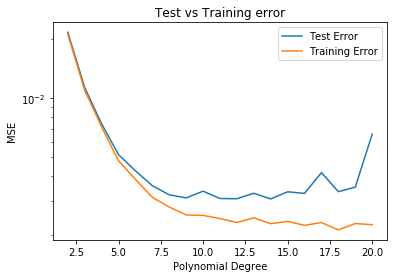

0

In [177]:
bias_variance(x_array, y_array, z_array, 'ols', lamb = 0, poly_order = 20, k=5, testtrainplot = True)

# 1c



polynomial degree:  0
R2 test is:  0.0
Error test is:  0.08566919273280907
-------------------------------
Global error is:  0.08056198458765003
bias is:  0.08053414138648719
variance is:  2.784320116282876e-05
0.080562 >= 0.080534 + 2.7843e-05 = 0.080562




polynomial degree:  1
R2 test is:  0.6857280582326204
Error test is:  0.027035560742501897
-------------------------------
Global error is:  0.020425092685896495
bias is:  0.020407542559383235
variance is:  1.7550126513260032e-05
0.020425 >= 0.020408 + 1.755e-05 = 0.020425




polynomial degree:  2
R2 test is:  0.7619741155200978
Error test is:  0.02002831226041909
-------------------------------
Global error is:  0.01739022961177634
bias is:  0.017364912480695657
variance is:  2.531713108068463e-05
0.01739 >= 0.017365 + 2.5317e-05 = 0.01739




polynomial degree:  3
R2 test is:  0.8685022389208777
Error test is:  0.010983688315491333
-------------------------------
Global error is:  0.01065503483602666
bias is:  0.0106215128044

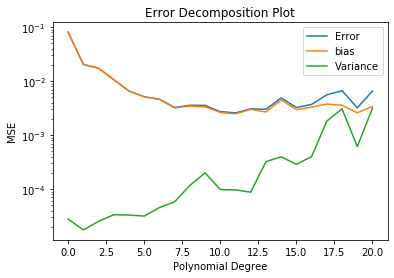

0

In [191]:
bias_variance(x_array, y_array, z_array, 'ols', lamb = 0, poly_order = 20, k=5, bvplot = True, printval = True)

# ridge

In [193]:
A = build_design_matrix(x_array, y_array, 5)

ridge_object = Regression_methods(A, z_array, lamb = 10000)

t = no_resample_analysis(ols_object, method = 'ridge', lamb = 10000)

NO RESAMPLE ANALYSIS
MSE:  0.004770265363644671
R2 Score:  0.9434995411632198
----Confidence Intervals for Selected Beta----
β0 = 0.395 +- 9.53e-06
β2 = -10.4 +- 4.33e-06
β4 = 25.9 +- 3.35e-06
β6 = 7.56 +- 5.48e-06
β8 = 23.0 +- 2.48e-06
β10 = 17.5 +- 1.93e-06
β12 = 41.0 +- 2.48e-06
β14 = -4.71 +- 1.69e-06
β16 = -49.0 +- 2.14e-06
β18 = -23.9 +- 3.32e-06
β20 = 1.82 +- 3.04e-06
